## Imports and Defines

In [25]:
import io
import os
import csv
import sys
import tqdm
import torch
import zipfile
import requests
import numpy as np
from torch import nn
from itertools import product
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Hyperparameters

In [2]:
IMAGE_SIZE = [512]
EPOCHS = [5]
LR = [0.005, 0.01]
MOMENTUM = [0.2, 0.9]
WEIGHT_DECAY = [0.0005, 0.001]
BATCH_SIZE = [25]

keys = ["image_size", "epochs", "lr", "momentum", "weight_decay", "batch_size"]
combos = product(IMAGE_SIZE, EPOCHS, LR, MOMENTUM, WEIGHT_DECAY, BATCH_SIZE)

combos = [dict(zip(keys, combo)) for combo in combos]


## Database Setups and Images Transforms

In [4]:
def db_setup(img_size):
    if "google.colab" in sys.modules:
        from google.colab import drive
        drive.mount('/content/drive')
        BASE_PATH = "/content/drive/MyDrive/chest_xray/processed/"
    else:
        BASE_PATH = os.path.join(os.getcwd(), "chest_xray/processed/")


    db_train = datasets.ImageFolder(root=BASE_PATH+'train', transform=None)
    db_val = datasets.ImageFolder(root=BASE_PATH+'val', transform=None)
    db_test = datasets.ImageFolder(root=BASE_PATH+'test', transform=None)


    db_train.transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.RandomResizedCrop(size=[img_size, img_size], scale=(0.5,1.)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
            mean=0.485,
            std=0.225
        )
    ])


    db_val.transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize([img_size, img_size]),
        # Resize the short side of the image to 256
        transforms.CenterCrop([img_size, img_size]),       # Crop a center patch of the image of size 224x224
        transforms.ToTensor(),            # Convert the image to tensor format
        transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
            mean= 0.406,
            std=0.225
        )
    ])

    db_test.transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize([img_size, img_size]),           # Resize the short side of the image to 256
        transforms.CenterCrop([img_size, img_size]),       # Crop a center patch of the image of size 224x224
        transforms.ToTensor(),            # Convert the image to tensor format
        transforms.Normalize(             # Normalize using ImageNet's mean and standard deviation
            mean=0.485,
            std=0.229
        )
    ])


    return db_train, db_val, db_test

## Training and Testing Funcitons

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)


@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    all_preds, all_labels = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)

        all_preds.extend(pred.argmax(1).cpu().tolist())
        all_labels.extend(labels.tolist())

        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies), all_preds, all_labels

@torch.no_grad()
def plot_cm(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='gray')
    plt.title("Confusion Matrix")
    plt.show()

    return cm

def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs + 1):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        val_l, val_acc, p, l = eval(model, loader_val)

        print(f"Finished epoch {epoch + 1} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc


def plot_training_history(combo_stats):
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    for combo, stats in combo_stats.items():
        c = dict(combo)
        label = f"lr={c['lr']}, mom={c['momentum']}, bs={c['batch_size']}"
        plt.plot(stats["hist_tr_acc"], label=f"{label} train")
        plt.plot(stats["hist_val_acc"], label=f"{label} val", linestyle="--")
    plt.ylim([0.4, 1.05])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend(fontsize=7)

    plt.subplot(1, 2, 2)
    for combo, stats in combo_stats.items():
        c = dict(combo)
        label = f"lr={c['lr']}, mom={c['momentum']}, bs={c['batch_size']}"
        plt.plot(stats["hist_tr_loss"], label=f"{label} train")
        plt.plot(stats["hist_val_loss"], label=f"{label} val", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend(fontsize=7)

    plt.tight_layout()
    plt.show()


## Fitting Different Hyperparameters

In [6]:
combo_stats = {}

for combo in combos:

    combo_key = tuple(combo.items())


    db_train, db_val, db_test = db_setup(combo["image_size"])

    model = models.resnet18()
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False
    )

    loader_train = DataLoader(db_train, batch_size=combo["batch_size"], shuffle=True, drop_last=True)
    loader_val = DataLoader(db_val, batch_size=combo["batch_size"], shuffle=False)
    loader_test = DataLoader(db_test, batch_size=combo["batch_size"], shuffle=False)

    model = model.to(device)

    opt = torch.optim.SGD(model.parameters(), lr=combo["lr"], momentum=combo["momentum"], weight_decay=combo["weight_decay"])

    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = fit(model, loader_train, loader_val, epochs=combo["epochs"], opt=opt)

    combo_stats[combo_key] = {
        "hist_tr_loss"   : hist_tr_loss,
        "hist_val_loss" : hist_val_loss,
        "hist_tr_acc"    : hist_tr_acc,
        "hist_val_acc"   : hist_val_acc
    }

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.30s/it]

Finished epoch 1 of 5: Train Loss = 0.555  Val Loss = 0.622   Train Acc = 0.825   Val Acc = 0.741



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 2 of 5: Train Loss = 0.301  Val Loss = 0.356   Train Acc = 0.865   Val Acc = 0.862



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.30s/it]

Finished epoch 3 of 5: Train Loss = 0.275  Val Loss = 0.324   Train Acc = 0.879   Val Acc = 0.876



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 4 of 5: Train Loss = 0.262  Val Loss = 0.393   Train Acc = 0.889   Val Acc = 0.833



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 5 of 5: Train Loss = 0.248  Val Loss = 0.316   Train Acc = 0.895   Val Acc = 0.875



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.30s/it]

Finished epoch 6 of 5: Train Loss = 0.244  Val Loss = 0.215   Train Acc = 0.899   Val Acc = 0.925



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 1 of 5: Train Loss = 0.564  Val Loss = 0.319   Train Acc = 0.836   Val Acc = 0.877



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:47<00:00,  1.31s/it]

Finished epoch 2 of 5: Train Loss = 0.303  Val Loss = 0.436   Train Acc = 0.871   Val Acc = 0.805



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 3 of 5: Train Loss = 0.274  Val Loss = 0.277   Train Acc = 0.879   Val Acc = 0.901



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 4 of 5: Train Loss = 0.258  Val Loss = 0.221   Train Acc = 0.890   Val Acc = 0.914



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 5 of 5: Train Loss = 0.250  Val Loss = 0.332   Train Acc = 0.897   Val Acc = 0.859



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]


Finished epoch 6 of 5: Train Loss = 0.235  Val Loss = 0.256   Train Acc = 0.902   Val Acc = 0.897


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 1 of 5: Train Loss = 0.512  Val Loss = 1.831   Train Acc = 0.831   Val Acc = 0.443



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 2 of 5: Train Loss = 0.286  Val Loss = 0.649   Train Acc = 0.886   Val Acc = 0.744



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:53<00:00,  1.49s/it]

Finished epoch 3 of 5: Train Loss = 0.258  Val Loss = 0.313   Train Acc = 0.897   Val Acc = 0.880



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 4 of 5: Train Loss = 0.254  Val Loss = 0.311   Train Acc = 0.900   Val Acc = 0.873



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 5 of 5: Train Loss = 0.230  Val Loss = 0.181   Train Acc = 0.908   Val Acc = 0.939



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 6 of 5: Train Loss = 0.235  Val Loss = 0.373   Train Acc = 0.903   Val Acc = 0.874



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 1 of 5: Train Loss = 0.494  Val Loss = 0.309   Train Acc = 0.827   Val Acc = 0.854



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 2 of 5: Train Loss = 0.286  Val Loss = 0.302   Train Acc = 0.882   Val Acc = 0.882



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 3 of 5: Train Loss = 0.283  Val Loss = 0.319   Train Acc = 0.878   Val Acc = 0.864



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 4 of 5: Train Loss = 0.238  Val Loss = 0.212   Train Acc = 0.903   Val Acc = 0.928



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 5 of 5: Train Loss = 0.250  Val Loss = 0.177   Train Acc = 0.907   Val Acc = 0.933



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 6 of 5: Train Loss = 0.230  Val Loss = 0.320   Train Acc = 0.909   Val Acc = 0.850



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 1 of 5: Train Loss = 0.471  Val Loss = 1.689   Train Acc = 0.840   Val Acc = 0.387



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 2 of 5: Train Loss = 0.290  Val Loss = 0.638   Train Acc = 0.873   Val Acc = 0.752



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:45<00:00,  1.28s/it]

Finished epoch 3 of 5: Train Loss = 0.276  Val Loss = 0.894   Train Acc = 0.888   Val Acc = 0.596



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.30s/it]

Finished epoch 4 of 5: Train Loss = 0.258  Val Loss = 0.346   Train Acc = 0.886   Val Acc = 0.864



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 5 of 5: Train Loss = 0.239  Val Loss = 0.539   Train Acc = 0.903   Val Acc = 0.766



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:49<00:00,  1.38s/it]

Finished epoch 6 of 5: Train Loss = 0.244  Val Loss = 0.221   Train Acc = 0.904   Val Acc = 0.930



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 1 of 5: Train Loss = 0.464  Val Loss = 1.707   Train Acc = 0.835   Val Acc = 0.373



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 2 of 5: Train Loss = 0.306  Val Loss = 0.334   Train Acc = 0.867   Val Acc = 0.861



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 3 of 5: Train Loss = 0.266  Val Loss = 0.341   Train Acc = 0.889   Val Acc = 0.866



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 4 of 5: Train Loss = 0.256  Val Loss = 0.312   Train Acc = 0.894   Val Acc = 0.864



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 5 of 5: Train Loss = 0.246  Val Loss = 0.180   Train Acc = 0.901   Val Acc = 0.934



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:45<00:00,  1.28s/it]

Finished epoch 6 of 5: Train Loss = 0.233  Val Loss = 0.220   Train Acc = 0.906   Val Acc = 0.934



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 1 of 5: Train Loss = 0.529  Val Loss = 0.241   Train Acc = 0.829   Val Acc = 0.909



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 2 of 5: Train Loss = 0.294  Val Loss = 0.535   Train Acc = 0.878   Val Acc = 0.777



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 3 of 5: Train Loss = 0.270  Val Loss = 0.299   Train Acc = 0.893   Val Acc = 0.893



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 4 of 5: Train Loss = 0.241  Val Loss = 0.167   Train Acc = 0.903   Val Acc = 0.931



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 5 of 5: Train Loss = 0.230  Val Loss = 0.203   Train Acc = 0.912   Val Acc = 0.923



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 6 of 5: Train Loss = 0.224  Val Loss = 0.729   Train Acc = 0.910   Val Acc = 0.710



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 1 of 5: Train Loss = 0.531  Val Loss = 0.781   Train Acc = 0.829   Val Acc = 0.669



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 2 of 5: Train Loss = 0.306  Val Loss = 0.256   Train Acc = 0.874   Val Acc = 0.902



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.29s/it]

Finished epoch 3 of 5: Train Loss = 0.266  Val Loss = 0.688   Train Acc = 0.895   Val Acc = 0.737



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 4 of 5: Train Loss = 0.227  Val Loss = 0.204   Train Acc = 0.912   Val Acc = 0.932



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.28s/it]

Finished epoch 5 of 5: Train Loss = 0.230  Val Loss = 0.545   Train Acc = 0.911   Val Acc = 0.771



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:47<00:00,  1.32s/it]

Finished epoch 6 of 5: Train Loss = 0.214  Val Loss = 0.358   Train Acc = 0.912   Val Acc = 0.850


## Choosing Best Hyperparameter Combination

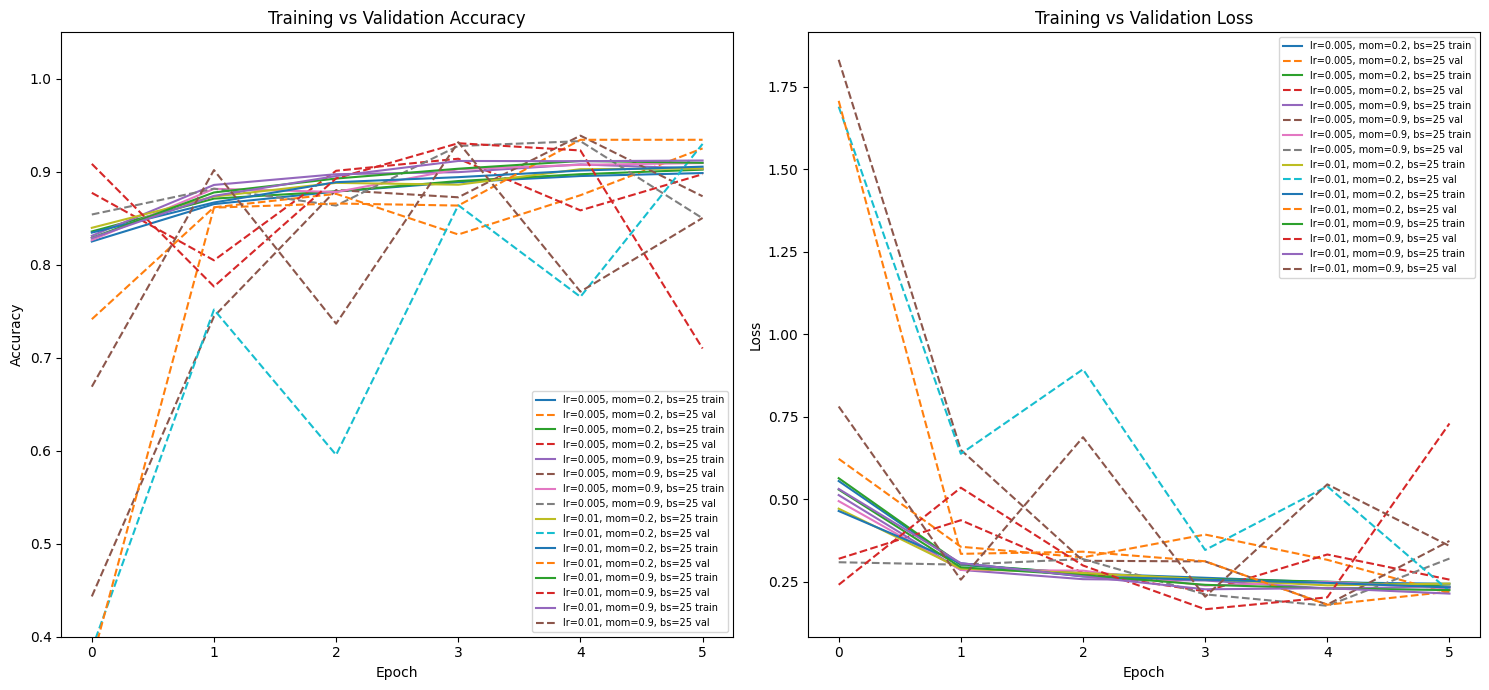

Best Val accuracy: 93.44%
Best Val loss: 0.220


In [39]:
plot_training_history(combo_stats)

best_combo = None
best_acc = -1
best_loss = None

for combo, stats in combo_stats.items():
    final_acc = stats["hist_val_acc"][-1]
    final_loss = stats["hist_val_loss"][-1]

    if final_acc > best_acc:
        best_acc = final_acc
        best_loss = final_loss
        best_combo = dict(combo)

print(f'Best Val accuracy: {best_acc*100:.2f}%')
print(f'Best Val loss: {best_loss:.3f}')

## Refit on Best

In [34]:
db_train, db_val, db_test = db_setup(best_combo["image_size"])
db_train_val = ConcatDataset([db_train, db_val])

model = models.resnet18()
model.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
    
loader_train = DataLoader(db_train_val, batch_size=best_combo["batch_size"], shuffle=True, drop_last=True)
loader_val = DataLoader(db_val, batch_size=best_combo["batch_size"], shuffle=False)
loader_test = DataLoader(db_test, batch_size=best_combo["batch_size"], shuffle=False)

model = model.to(device)

opt = torch.optim.SGD(model.parameters(), lr=best_combo["lr"], momentum=best_combo["momentum"], weight_decay=best_combo["weight_decay"])

fit(model, loader_train, loader_val, epochs=best_combo["epochs"], opt=opt)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:48<00:00,  1.36s/it]

Finished epoch 1 of 5: Train Loss = 0.452  Val Loss = 0.266   Train Acc = 0.837   Val Acc = 0.896



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:45<00:00,  1.27s/it]

Finished epoch 2 of 5: Train Loss = 0.286  Val Loss = 0.957   Train Acc = 0.876   Val Acc = 0.656



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:45<00:00,  1.27s/it]

Finished epoch 3 of 5: Train Loss = 0.252  Val Loss = 0.223   Train Acc = 0.894   Val Acc = 0.926



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.62s/it]

Finished epoch 4 of 5: Train Loss = 0.249  Val Loss = 0.210   Train Acc = 0.898   Val Acc = 0.920



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:52<00:00,  1.47s/it]

Finished epoch 5 of 5: Train Loss = 0.231  Val Loss = 0.344   Train Acc = 0.908   Val Acc = 0.854



100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:49<00:00,  1.36s/it]

Finished epoch 6 of 5: Train Loss = 0.221  Val Loss = 0.152   Train Acc = 0.911   Val Acc = 0.946


([0.4523046246949752,
  0.2861309903088826,
  0.25214745755770696,
  0.2492510659348725,
  0.2310484266610601,
  0.22087336698518925],
 [0.2657619067985151,
  0.9568069033686899,
  0.22306059611340365,
  0.20979699026793242,
  0.34426127951074803,
  0.1517623360786173],
 [0.8371859046083,
  0.875577866132535,
  0.8940703284800352,
  0.8984924390088374,
  0.9075376663974781,
  0.9109547497639104],
 [0.8962962743308809,
  0.6555555471115642,
  0.925555537144343,
  0.9196296168698205,
  0.8537036817934778,
  0.9455555412504408])

In [35]:
test_loss, test_acc, test_preds, test_labels = eval(model, loader_test)
print(f"Final TEST loss: {test_loss:.3f}, TEST acc: {test_acc:.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.61s/it]

Final TEST loss: 0.170, TEST acc: 0.943


## Results

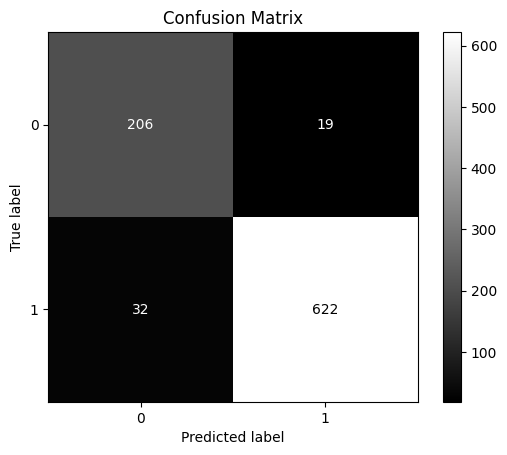

[[206  19]
 [ 32 622]]


In [37]:
cm = plot_cm(test_preds, test_labels)
print(cm)